In [32]:
import pandas as pd
import os
import sys
import warnings

from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

warnings.filterwarnings("ignore", "is_categorical_dtype")
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
warnings.simplefilter(action='ignore', category=RuntimeWarning)




In [2]:
local_dir = os.getcwd()

eggnogg_annot = pd.read_csv('{}filtered_panpangenome.emapper.annotations'.format(local_dir+'/accessory_data/'), sep='\t', index_col=0, skiprows=[0,1,2,3])

eggnogg_annot = eggnogg_annot.iloc[:-3]
eggnogg_annot = eggnogg_annot.reset_index()

go_terms = eggnogg_annot['GOs']
go_terms.index = eggnogg_annot['#query']
go_terms.replace(to_replace='-', value='NA', inplace=True)



In [3]:
def make_gene_cluster_go_dict(go_df, gene_cluster_go_dict):
    for gene in go_df.index:
        GC = gene.split("|")[1]
        go_terms = go_df[gene]
        if GC in gene_cluster_go_dict:
            gene_cluster_go_dict[GC].append(go_terms)
        else:
            gene_cluster_go_dict[GC] = [go_terms]
        
    return gene_cluster_go_dict


def consolidate_go_annotation(go_dict):
    robust_go_dict = {}
    for GC in go_dict:
        go_terms = go_dict[GC]
        go_terms_counts = Counter(go_terms)
        GC_gene_count = len(go_terms)
        if 'NA' in go_terms_counts:
            del go_terms_counts['NA']
        if len(go_terms_counts) > 0:
            most_common_go = go_terms_counts.most_common(1)[0][0]
            #check what % of genes have the most common go term
            most_common_go_count = go_terms_counts[most_common_go]
            most_common_go_percent = most_common_go_count / GC_gene_count
            #print (most_common_go_percent)
            if len(go_terms_counts.keys()) == 1:
                if most_common_go_percent >= 0.2:
                    robust_go_dict[GC] = most_common_go
                    #print (GC, most_common_go)
                else:
                    robust_go_dict[GC] = 'NA'
            else:
                #split the go keys into lists and count the number of genes with each go term
                go_keys = {}
                for go_list in go_terms_counts.keys():
                    go_term_list = go_list.split(',')
                    for go in go_term_list:
                        if go in go_keys.keys():
                            go_keys[go] += go_terms_counts[go_list]
                        else:
                            go_keys[go] = go_terms_counts[go_list]
                #now show what are the most common go terms
                go_keys_counts = Counter(go_keys)
                most_common_go = go_keys_counts.most_common()
                robust_list = []
                for go_pair in most_common_go:
                    go = go_pair[0]
                    go_percent = go_pair[1] / GC_gene_count
                    if go_percent >= 0.2:
                        robust_list.append(go)
                        #print (GC, go)
                if len(robust_list) > 0:
                    robust_go_dict[GC] = ','.join(robust_list)
                else:
                    robust_go_dict[GC] = 'NA'
        else:
            robust_go_dict[GC] = 'NA'

    return robust_go_dict



In [4]:
go_dict = {}

go_dict = make_gene_cluster_go_dict(go_terms, go_dict)

print (len(go_dict.keys()))


35620


In [5]:

orphan_eggnogg_annot = pd.read_csv('{}eggnogg_orphan.emapper.annotations'.format(os.getcwd()+'/accessory_data/'), sep='\t', index_col=0, skiprows=[0,1,2,3])
orphan_eggnogg_annot = orphan_eggnogg_annot.iloc[:-3]
orphan_eggnogg_annot = orphan_eggnogg_annot.reset_index()

orphan_go_terms = orphan_eggnogg_annot['GOs']
orphan_go_terms.index = orphan_eggnogg_annot['#query']
orphan_go_terms.replace(to_replace='-', value='NA', inplace=True)

In [6]:
go_dict = make_gene_cluster_go_dict(orphan_go_terms, go_dict)

In [7]:
#print orphan go terms with no NA

print (orphan_go_terms[orphan_go_terms != 'NA'])


#query
01770344|gene_cluster:GC_00009427|genome_name:CALOQF01|gene_callers_id:5583    GO:0000041,GO:0003674,GO:0005215,GO:0005381,GO...
Name: GOs, dtype: object


In [8]:
print (len(go_dict.keys()))

35648


In [9]:
print (go_dict.keys())
print (len(go_dict.keys()))

dict_keys(['gene_cluster:GC_00018106', 'gene_cluster:GC_00022444', 'gene_cluster:GC_00017500', 'gene_cluster:GC_00017920', 'gene_cluster:GC_00011486', 'gene_cluster:GC_00035636', 'gene_cluster:GC_00001958', 'gene_cluster:GC_00018720', 'gene_cluster:GC_00007335', 'gene_cluster:GC_00006622', 'gene_cluster:GC_00018893', 'gene_cluster:GC_00012313', 'gene_cluster:GC_00024028', 'gene_cluster:GC_00027934', 'gene_cluster:GC_00030910', 'gene_cluster:GC_00003991', 'gene_cluster:GC_00028635', 'gene_cluster:GC_00024194', 'gene_cluster:GC_00035969', 'gene_cluster:GC_00023317', 'gene_cluster:GC_00016991', 'gene_cluster:GC_00021972', 'gene_cluster:GC_00012425', 'gene_cluster:GC_00000325', 'gene_cluster:GC_00015956', 'gene_cluster:GC_00029967', 'gene_cluster:GC_00002909', 'gene_cluster:GC_00035639', 'gene_cluster:GC_00027556', 'gene_cluster:GC_00012086', 'gene_cluster:GC_00005439', 'gene_cluster:GC_00016719', 'gene_cluster:GC_00003259', 'gene_cluster:GC_00014856', 'gene_cluster:GC_00020630', 'gene_clu

In [10]:
robust_go_dict = consolidate_go_annotation(go_dict)

robust_go_df = pd.DataFrame.from_dict(robust_go_dict, orient='index', columns=['GO_terms'])
print (robust_go_df.head())




                                                                   GO_terms
gene_cluster:GC_00018106                                                 NA
gene_cluster:GC_00022444                                                 NA
gene_cluster:GC_00017500  GO:0005575,GO:0005623,GO:0005886,GO:0016020,GO...
gene_cluster:GC_00017920                                                 NA
gene_cluster:GC_00011486                                                 NA


In [11]:
#turn the df around, get all the GO terms and which GC are associated with it
go_term_dict = {}

for GC in robust_go_df.index:
    go_terms = robust_go_df.loc[GC]['GO_terms']
    if go_terms != "NA":
        go_term_list = go_terms.split(',')
        for go in go_term_list:
            if go in go_term_dict:
                go_term_dict[go].append(GC)
            else:
                go_term_dict[go] = [GC]

go_gc_df = pd.DataFrame(0, index=go_term_dict.keys(), columns=robust_go_df.index)

gc_go_df = pd.DataFrame(0, index=robust_go_df.index, columns=go_term_dict.keys())

for go in go_term_dict:
    GC_list = go_term_dict[go]
    for GC in GC_list:
        go_gc_df.loc[go][GC] = 1
        gc_go_df.loc[GC][go] = 1

#now do it but keep the NAs in the GC_go_df

go_term_dict = {}

for GC in robust_go_df.index:
    go_terms = robust_go_df.loc[GC]['GO_terms']
    if go_terms != "NA":
        go_term_list = go_terms.split(',')
        for go in go_term_list:
            if go in go_term_dict:
                go_term_dict[go].append(GC)
            else:
                go_term_dict[go] = [GC]
    else:
        if 'NA' in go_term_dict:
            go_term_dict['NA'].append(GC)
        else:
            go_term_dict['NA'] = [GC]

GC_go_df = pd.DataFrame(0, index=robust_go_df.index, columns=go_term_dict.keys())

for go in go_term_dict:
    GC_list = go_term_dict[go]
    for GC in GC_list:
        GC_go_df.loc[GC][go] += 1

print (GC_go_df.head())
print (GC_go_df.sum())
print (GC_go_df.sum(axis=1))

                          NA  GO:0005575  GO:0005623  GO:0005886  GO:0016020  \
gene_cluster:GC_00018106   1           0           0           0           0   
gene_cluster:GC_00022444   1           0           0           0           0   
gene_cluster:GC_00017500   0           1           1           1           1   
gene_cluster:GC_00017920   1           0           0           0           0   
gene_cluster:GC_00011486   1           0           0           0           0   

                          GO:0044464  GO:0071944  GO:0003674  GO:0003824  \
gene_cluster:GC_00018106           0           0           0           0   
gene_cluster:GC_00022444           0           0           0           0   
gene_cluster:GC_00017500           1           1           0           0   
gene_cluster:GC_00017920           0           0           0           0   
gene_cluster:GC_00011486           0           0           0           0   

                          GO:0008150  ...  GO:0004014  GO:0009

In [12]:
print (gc_go_df.sum(axis=0).sort_values(ascending=False).head(5))
print (go_gc_df.sum(axis=0).sort_values(ascending=False).head(5))

taxa_df = pd.read_csv('{}family_gtdbtk_annot.tsv'.format(os.getcwd()+'/accessory_data/'), sep='\t', index_col=0, header=None)

genome_gene_cluster_df = pd.read_csv('{}pairwise_presence_absence.tsv'.format(os.getcwd()+'/accessory_data/'), sep='\t', index_col=0)

print (taxa_df.head())
print (genome_gene_cluster_df.head())

GO:0008150    3898
GO:0005575    3492
GO:0003674    3478
GO:0044464    3369
GO:0005623    3369
dtype: int64
gene_cluster:GC_00004047    369
gene_cluster:GC_00029583    244
gene_cluster:GC_00016109    219
gene_cluster:GC_00003477    217
gene_cluster:GC_00006806    186
dtype: int64
                          1
0                          
CALOFZ02   Pseudomonadaceae
CALOGA02  Sphingomonadaceae
CALOGB02  Sphingomonadaceae
CALOGC02   Pseudomonadaceae
CALOGD02   Pseudomonadaceae
          GC_00000001  GC_00000002  GC_00000003  GC_00000004  GC_00000005  \
layer                                                                       
CALOFZ02            0            1            1            1            1   
CALOGA02            1            1            0            0            1   
CALOGB02            0            1            0            0            0   
CALOGC02            1            1            1            1            1   
CALOGD02            1            1            1            1 

In [34]:
#print (taxa_df.shape)
#print (genome_gene_cluster_df.shape)

#make a df that for each go term, has the number of sphingomonadaceae genes that have that go term and non-sphingomonadaceae genes that have that go term

go_df = pd.DataFrame(0, index=go_gc_df.index, columns=['Sphingomonadaceae', 'Non-Sphingomonadaceae', 'fold_change'])

filtered_taxa = taxa_df.loc[genome_gene_cluster_df.index]
sphingo_genomes = filtered_taxa[filtered_taxa.loc[:, 1] == 'Sphingomonadaceae'].index
non_sphingo_genomes = filtered_taxa[filtered_taxa.loc[:, 1] != 'Sphingomonadaceae'].index

debug_table = pd.DataFrame(0, index=go_gc_df.index, columns=['GC_list_size', 'Sphingo_count', 'Non_Sphingo_count'])

for go in go_gc_df.index:
    #check in which GC the go term is present
    GC_list = go_gc_df.loc[go][go_gc_df.loc[go] == 1].index
    #print (GC_list)
    #check how many of those GC are in sphingomonadaceae
    sphingomonadaceae_count = 0
    non_sphingomonadaceae_count = 0
    GC_LIST = [GC.split(":")[1] for GC in GC_list]
    #print (len(GC_list), genome_gene_cluster_df.loc[sphingo_genomes, GC_LIST].sum().sum(), genome_gene_cluster_df.loc[non_sphingo_genomes, GC_LIST].sum().sum())
    debug_table.loc[go, 'GC_list_size'] = len(GC_list)
    debug_table.loc[go, 'Sphingo_count'] = genome_gene_cluster_df.loc[sphingo_genomes, GC_LIST].sum().sum()/len(sphingo_genomes)
    debug_table.loc[go, 'Non_Sphingo_count'] = genome_gene_cluster_df.loc[non_sphingo_genomes, GC_LIST].sum().sum()/len(non_sphingo_genomes)
    for GC in GC_list:
        GC = GC.split(":")[1]
        sphingomonadaceae_count += genome_gene_cluster_df.loc[sphingo_genomes, GC].sum()
        non_sphingomonadaceae_count += genome_gene_cluster_df.loc[non_sphingo_genomes, GC].sum()  
    go_df.loc[go, 'Sphingomonadaceae'] = sphingomonadaceae_count
    go_df.loc[go, 'Non-Sphingomonadaceae'] = non_sphingomonadaceae_count
    go_df.loc[go, 'fold_change'] = (sphingomonadaceae_count/len(sphingo_genomes))/(non_sphingomonadaceae_count/len(non_sphingo_genomes))

print (len(sphingo_genomes), len(non_sphingo_genomes))

print (debug_table)

for go in go_df.index:
    if go_df.loc[go, 'Non-Sphingomonadaceae'] == 0:
        go_df.loc[go, 'fold_change'] = go_df.loc[go, 'Sphingomonadaceae']/len(sphingo_genomes)/(1/len(non_sphingo_genomes))



455 805
            GC_list_size  Sphingo_count  Non_Sphingo_count
GO:0005575          3492     251.118681         577.245963
GO:0005623          3369     246.518681         565.227329
GO:0005886          1376      26.786813         173.480745
GO:0016020          1522      29.496703         190.086957
GO:0044464          3369     246.518681         565.227329
...                  ...            ...                ...
GO:0036447             1       0.000000           0.042236
GO:0036448             1       0.000000           0.042236
GO:0006115             1       0.000000           0.042236
GO:0034309             1       0.000000           0.042236
GO:0004801             1       0.002198           0.577640

[5960 rows x 3 columns]


['GC_00018893', 'GC_00017581', 'GC_00008593', 'GC_00000113', 'GC_00025378', 'GC_00017574', 'GC_00003568', 'GC_00008165', 'GC_00007129', 'GC_00021527', 'GC_00023798', 'GC_00009875', 'GC_00023410', 'GC_00033559', 'GC_00016332', 'GC_00023011', 'GC_00033653', 'GC_00027986', 'GC_00007930', 'GC_00001924', 'GC_00000596', 'GC_00012884', 'GC_00037340', 'GC_00004031', 'GC_00006288', 'GC_00026103', 'GC_00009961', 'GC_00012161', 'GC_00008694', 'GC_00015961', 'GC_00005057', 'GC_00005943', 'GC_00022284', 'GC_00016566', 'GC_00008055', 'GC_00025272', 'GC_00002399', 'GC_00006182', 'GC_00034904', 'GC_00026250', 'GC_00020081', 'GC_00003028', 'GC_00005291', 'GC_00000155', 'GC_00017099', 'GC_00004502', 'GC_00002855', 'GC_00000613', 'GC_00035992', 'GC_00025618', 'GC_00033994', 'GC_00025081', 'GC_00008312', 'GC_00034225', 'GC_00009024', 'GC_00028499', 'GC_00002911', 'GC_00010969', 'GC_00013598', 'GC_00022728', 'GC_00022282', 'GC_00005892', 'GC_00000221', 'GC_00032826', 'GC_00000076', 'GC_00017173', 'GC_00023

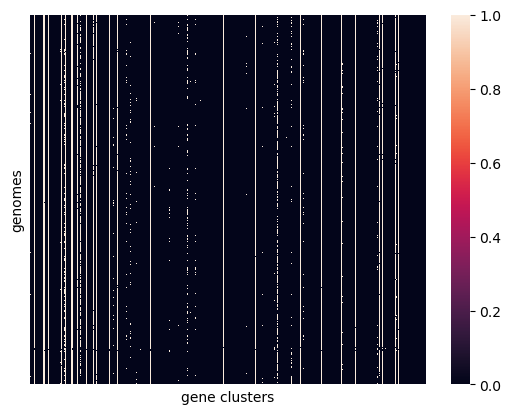

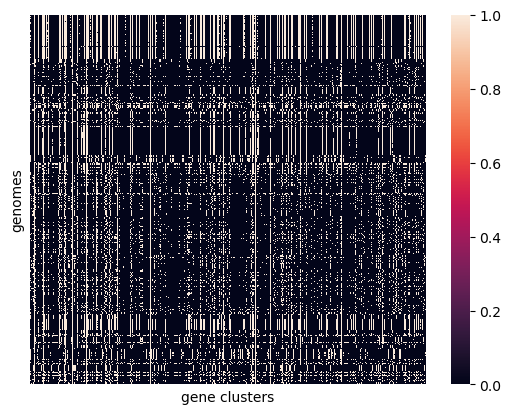

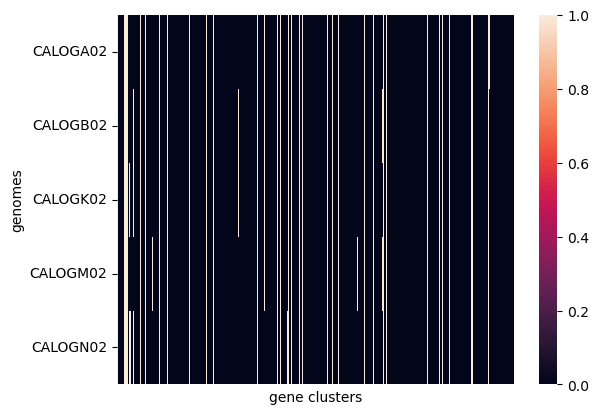

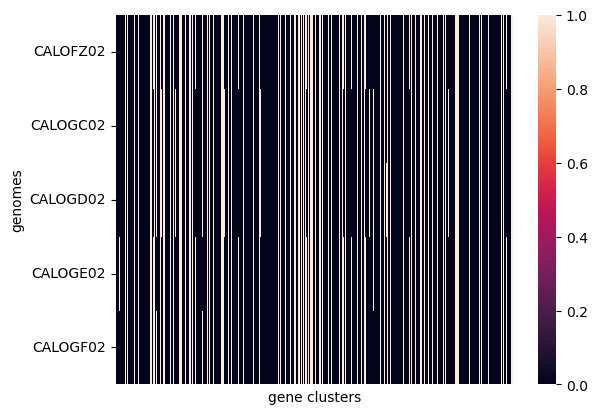

                          1
0                          
CALOGA02  Sphingomonadaceae
CALOGB02  Sphingomonadaceae
CALOGK02  Sphingomonadaceae
CALOGM02  Sphingomonadaceae
CALOGN02  Sphingomonadaceae
                         1
0                         
CALOFZ02  Pseudomonadaceae
CALOGC02  Pseudomonadaceae
CALOGD02  Pseudomonadaceae
CALOGE02  Pseudomonadaceae
CALOGF02  Pseudomonadaceae


In [14]:
GC_list = go_gc_df.loc['GO:0003674'][go_gc_df.loc['GO:0003674'] == 1].index
GC_LIST = [GC.split(":")[1] for GC in GC_list]

print (GC_LIST)
print (genome_gene_cluster_df.loc[sphingo_genomes].sum().sum()/len(sphingo_genomes))
print (genome_gene_cluster_df.loc[non_sphingo_genomes].sum().sum()/len(non_sphingo_genomes))
print (genome_gene_cluster_df.loc[sphingo_genomes, GC_LIST].sum().sum())
print (genome_gene_cluster_df.loc[non_sphingo_genomes, GC_LIST].sum().sum())

#make a heatmap and hide the labels
sns.heatmap(genome_gene_cluster_df.loc[sphingo_genomes, GC_LIST])
plt.yticks([])
plt.xticks([])
plt.ylabel('genomes')
plt.xlabel('gene clusters')
plt.show()

sns.heatmap(genome_gene_cluster_df.loc[non_sphingo_genomes, GC_LIST])
plt.yticks([])
plt.xticks([])
plt.ylabel('genomes')
plt.xlabel('gene clusters')
plt.show()

#print (genome_gene_cluster_df.loc[sphingo_genomes, GC_LIST])
#print (genome_gene_cluster_df.loc[non_sphingo_genomes, GC_LIST])

shortlist_sphingo = ['CALOGA02', 'CALOGB02', 'CALOGK02', 'CALOGM02', 'CALOGN02']
sns.heatmap(genome_gene_cluster_df.loc[shortlist_sphingo, GC_LIST])
#plt.yticks([])
plt.xticks([])
plt.ylabel('genomes')
plt.xlabel('gene clusters')
plt.show()


shortlist_nonsphingo = ['CALOFZ02' ,'CALOGC02', 'CALOGD02', 'CALOGE02', 'CALOGF02']
#show the genome_gene_cluster_df for the shortlisted genomes and hide the columns that are all 0
sns.heatmap(genome_gene_cluster_df.loc[shortlist_nonsphingo, GC_LIST])
#plt.yticks([])
plt.xticks([])
plt.ylabel('genomes')
plt.xlabel('gene clusters')
plt.show()

print (taxa_df.loc[shortlist_sphingo])
print (taxa_df.loc[shortlist_nonsphingo])



In [15]:
#count the % of gene clusters that are annotated with at least one GO term in sphingo and non-sphingo
sphingo_go_count_annotated = 0
non_sphingo_go_count_annotated = 0
sphingo_go_count_not_annotated = 0
non_sphingo_go_count_not_annotated = 0

#print (gc_go_df)
#print (genome_gene_cluster_df)

debug_gene_cluster_per_genome = pd.DataFrame(0, index=[], columns=['Sphingo_count', 'Non_Sphingo_count', 'Sphingo_count_annotated', 'Non_Sphingo_count_annotated', 'Sphingo_count_not_annotated', 'Non_Sphingo_count_not_annotated'])

for GC in gc_go_df.index:
    #for each GC, count how many times it's in the sphingo genomes
    gc = GC.split(":")[1]
    sphingo_count = genome_gene_cluster_df.loc[sphingo_genomes, gc].sum()
    non_sphingo_count = genome_gene_cluster_df.loc[non_sphingo_genomes, gc].sum()
    #now check if the GC has a GO term
    if gc_go_df.loc[GC].sum() > 0:
        #if it has a GO term, add it to the count
        debug_gene_cluster_per_genome.loc[GC, 'Sphingo_count_annotated'] = sphingo_count
        debug_gene_cluster_per_genome.loc[GC, 'Non_Sphingo_count_annotated'] = non_sphingo_count
    else:   
        #if it doesn't have a GO term, add it to the count
        debug_gene_cluster_per_genome.loc[GC, 'Sphingo_count_not_annotated'] = sphingo_count
        debug_gene_cluster_per_genome.loc[GC, 'Non_Sphingo_count_not_annotated'] = non_sphingo_count
    
    debug_gene_cluster_per_genome.loc[GC, 'Sphingo_count'] = sphingo_count
    debug_gene_cluster_per_genome.loc[GC, 'Non_Sphingo_count'] = non_sphingo_count
    

    #debug_gene_cluster_per_genome.loc[GC, 'Sphingo_count'] = sphingo_count
    #debug_gene_cluster_per_genome.loc[GC, 'Non_Sphingo_count'] = non_sphingo_count

debug_gene_cluster_per_genome.fillna(0, inplace=True)
print (debug_gene_cluster_per_genome)

#    if gc_go_df.loc[GC].sum() > 0:
#        print (gc_go_df.loc[GC][gc_go_df.loc[GC] == 1].sum())


                          Sphingo_count  Non_Sphingo_count  \
gene_cluster:GC_00018106           51.0                0.0   
gene_cluster:GC_00022444            0.0               27.0   
gene_cluster:GC_00017500            0.0               55.0   
gene_cluster:GC_00017920            0.0               52.0   
gene_cluster:GC_00011486            0.0              100.0   
...                                 ...                ...   
gene_cluster:GC_00014235           72.0                0.0   
gene_cluster:GC_00033304           23.0                0.0   
gene_cluster:GC_00019336           46.0                0.0   
gene_cluster:GC_00005403          148.0                0.0   
gene_cluster:GC_00022972           37.0                0.0   

                          Sphingo_count_annotated  \
gene_cluster:GC_00018106                      0.0   
gene_cluster:GC_00022444                      0.0   
gene_cluster:GC_00017500                      0.0   
gene_cluster:GC_00017920                   

In [16]:
#create a dataframe with the genomes as index and the columns are the number of GCs, the number of GCs with a GO term, the number of GCs without a GO term and the taxonomic annotation
genome_go_df = pd.DataFrame(0, index=genome_gene_cluster_df.index, columns=['GC_count', 'GC_with_GO_count', 'GC_without_GO_count', 'taxa'])


for genome in genome_gene_cluster_df.index:
    #print (genome)
    gene_clusters = genome_gene_cluster_df.loc[genome][genome_gene_cluster_df.loc[genome] == 1].index
    gene_clusters = ['gene_cluster:{}'.format(gc) for gc in gene_clusters]
    GC_count = genome_gene_cluster_df.loc[genome].sum()
    #check which gene clusters are in the GC_go_df index
    shared_gene_clusters = list(set(GC_go_df.index).intersection(set(gene_clusters)))
    #check which gene clusters are not in the gc_go_df index
    not_shared_gene_clusters = set(gene_clusters) - set(GC_go_df.index)
    #print (GC_count, len(shared_gene_clusters), len(not_shared_gene_clusters), len(shared_gene_clusters) + len(not_shared_gene_clusters))
    NA_count = GC_go_df.loc[shared_gene_clusters, 'NA'].sum()
    NA_count = NA_count + len(not_shared_gene_clusters)
    #print (NA_count)
    #print (GC_count-NA_count)    

    taxa = taxa_df.loc[genome][1]
    genome_go_df.loc[genome, 'GC_count'] = GC_count
    genome_go_df.loc[genome, 'GC_with_GO_count'] = GC_count - NA_count
    genome_go_df.loc[genome, 'GC_without_GO_count'] = NA_count
    genome_go_df.loc[genome, 'taxa'] = taxa
    print (taxa, len(not_shared_gene_clusters))


print (genome_go_df)

GC_not_in_go_df = set(genome_gene_cluster_df.columns) - set([x.split(":")[1] for x in  gc_go_df.index])
print (GC_not_in_go_df)
GC_not_in_go_df_text = '\n'.join(GC_not_in_go_df)
outfile = open('{}GC_not_in_go_df.txt'.format(os.getcwd()+'/accessory_data/'), 'w')
outfile.write(GC_not_in_go_df_text)
outfile.close()
print (len(GC_not_in_go_df))


(35648, 5961)
(35648, 5960)
(1260, 37060)
          GC_00000001  GC_00000002  GC_00000003  GC_00000004  GC_00000005  \
layer                                                                       
CALOFZ02            0            1            1            1            1   
CALOGA02            1            1            0            0            1   
CALOGB02            0            1            0            0            0   
CALOGC02            1            1            1            1            1   
CALOGD02            1            1            1            1            1   
...               ...          ...          ...          ...          ...   
S65                 0            1            1            0            1   
S7                  0            1            1            0            1   
S71                 0            1            1            0            1   
S72                 1            1            1            1            1   
Si1                 0            1

/tmp/ipykernel_1087141/3691265187.py:30: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'Pseudomonadaceae' has dtype incompatible with int64, please explicitly cast to a compatible dtype first.
  genome_go_df.loc[genome, 'taxa'] = taxa


Sphingomonadaceae 106
Sphingomonadaceae 31
Sphingomonadaceae 92
Sphingomonadaceae 91
Pseudomonadaceae 11
Pseudomonadaceae 64
Sphingomonadaceae 32
Pseudomonadaceae 70
Pseudomonadaceae 56
Sphingomonadaceae 28
Pseudomonadaceae 68
Pseudomonadaceae 47
Pseudomonadaceae 41
Sphingomonadaceae 118
Pseudomonadaceae 58
Sphingomonadaceae 73
Sphingomonadaceae 149
Sphingomonadaceae 30
Sphingomonadaceae 145
Pseudomonadaceae 43
Sphingomonadaceae 148
Sphingomonadaceae 95
Pseudomonadaceae 68
Sphingomonadaceae 148
Pseudomonadaceae 58
Pseudomonadaceae 67
Sphingomonadaceae 148
Sphingomonadaceae 33
Sphingomonadaceae 63
Pseudomonadaceae 46
Sphingomonadaceae 31
Sphingomonadaceae 61
Pseudomonadaceae 13
Pseudomonadaceae 3
Pseudomonadaceae 68
Sphingomonadaceae 96
Sphingomonadaceae 97
Pseudomonadaceae 64
Pseudomonadaceae 65
Pseudomonadaceae 55
Pseudomonadaceae 51
Pseudomonadaceae 61
Pseudomonadaceae 61
Sphingomonadaceae 33
Sphingomonadaceae 148
Pseudomonadaceae 67
Pseudomonadaceae 7
Pseudomonadaceae 42
Pseudomonad

/home/vtracann/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vtracann/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vtracann/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vtracann/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

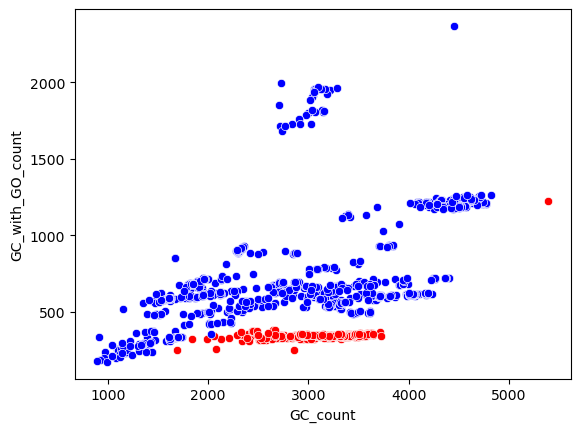

/home/vtracann/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vtracann/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vtracann/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/vtracann/miniconda3/lib/python3.9/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, Catego

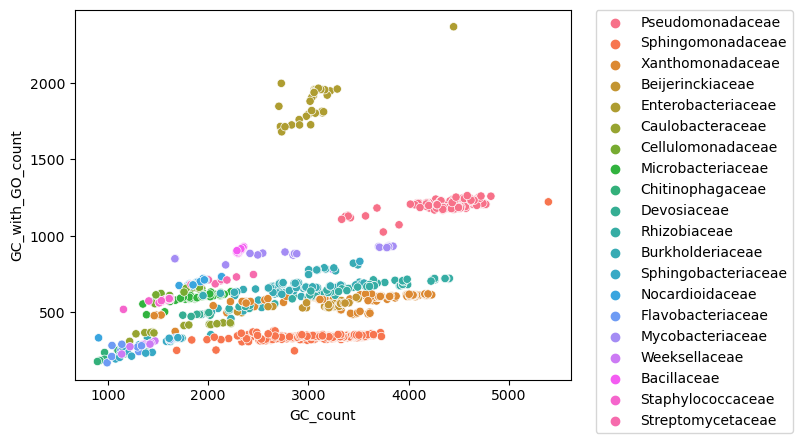

In [17]:
#now plot a scatter plot of the number of GCs with a GO term vs the number of total GCs, and color the points by sphingo vs non-sphingo
#first plot the sphingo genomes

plt.figsize=(10,10)

sns.scatterplot(x='GC_count', y='GC_with_GO_count', data=genome_go_df[genome_go_df['taxa'] == 'Sphingomonadaceae'], color='red')
sns.scatterplot(x='GC_count', y='GC_with_GO_count', data=genome_go_df[genome_go_df['taxa'] != 'Sphingomonadaceae'], color='blue')
plt.show()
sns.scatterplot(x='GC_count', y='GC_with_GO_count', data=genome_go_df, hue='taxa')
#put plot outside
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()


In [18]:
print (debug_gene_cluster_per_genome.sum(axis=0))
print (debug_gene_cluster_per_genome.loc[:, 'Sphingo_count_annotated'].sum(axis=0)/len(sphingo_genomes))
print (debug_gene_cluster_per_genome.loc[:, 'Non_Sphingo_count_annotated'].sum(axis=0)/len(non_sphingo_genomes))
print (debug_gene_cluster_per_genome.loc[:, 'Sphingo_count_not_annotated'].sum(axis=0)/len(sphingo_genomes))
print (debug_gene_cluster_per_genome.loc[:, 'Non_Sphingo_count_not_annotated'].sum(axis=0)/len(non_sphingo_genomes))
print (debug_gene_cluster_per_genome.loc[:, 'Sphingo_count'].sum(axis=0)/len(sphingo_genomes))
print (debug_gene_cluster_per_genome.loc[:, 'Non_Sphingo_count'].sum(axis=0)/len(non_sphingo_genomes))


Sphingo_count                      1423224.0
Non_Sphingo_count                  2430493.0
Sphingo_count_annotated             156333.0
Non_Sphingo_count_annotated         625743.0
Sphingo_count_not_annotated        1266891.0
Non_Sphingo_count_not_annotated    1804750.0
dtype: float64
343.589010989011
777.32049689441
2784.375824175824
2241.9254658385094
3127.964835164835
3019.2459627329195


In [19]:
#plot in a scatterplot per genome number of gc vs number of gc with go term
#color sphingo vs non-sphingo

print (genome_gene_cluster_df.sum(axis=1))

x = genome_gene_cluster_df.sum(axis=1)
print (debug_gene_cluster_per_genome)


layer
CALOFZ02    4631
CALOGA02    3356
CALOGB02    3305
CALOGC02    4729
CALOGD02    4700
            ... 
S65         1760
S7          1850
S71         1850
S72         1950
Si1         1699
Length: 1260, dtype: int64
                          Sphingo_count  Non_Sphingo_count  \
gene_cluster:GC_00018106           51.0                0.0   
gene_cluster:GC_00022444            0.0               27.0   
gene_cluster:GC_00017500            0.0               55.0   
gene_cluster:GC_00017920            0.0               52.0   
gene_cluster:GC_00011486            0.0              100.0   
...                                 ...                ...   
gene_cluster:GC_00014235           72.0                0.0   
gene_cluster:GC_00033304           23.0                0.0   
gene_cluster:GC_00019336           46.0                0.0   
gene_cluster:GC_00005403          148.0                0.0   
gene_cluster:GC_00022972           37.0                0.0   

                          Sphingo_c

In [20]:
print (debug_table)
normalized_debug_table = debug_table.copy()

for go in normalized_debug_table.index:
    normalized_debug_table.loc[go, 'Sphingo_count'] = debug_table.loc[go, 'Sphingo_count']/len(sphingo_genomes)
    normalized_debug_table.loc[go, 'Non_Sphingo_count'] = debug_table.loc[go, 'Non_Sphingo_count']/len(non_sphingo_genomes)
print (normalized_debug_table)


            GC_list_size  Sphingo_count  Non_Sphingo_count
GO:0005575          3492     251.118681         577.245963
GO:0005623          3369     246.518681         565.227329
GO:0005886          1376      26.786813         173.480745
GO:0016020          1522      29.496703         190.086957
GO:0044464          3369     246.518681         565.227329
...                  ...            ...                ...
GO:0036447             1       0.000000           0.042236
GO:0036448             1       0.000000           0.042236
GO:0006115             1       0.000000           0.042236
GO:0034309             1       0.000000           0.042236
GO:0004801             1       0.002198           0.577640

[5960 rows x 3 columns]
            GC_list_size  Sphingo_count  Non_Sphingo_count
GO:0005575          3492       0.551909           0.717076
GO:0005623          3369       0.541799           0.702146
GO:0005886          1376       0.058872           0.215504
GO:0016020          1522       

In [35]:
#print (len(sphingo_genomes))
#print (len(non_sphingo_genomes))

print (genome_gene_cluster_df.loc[sphingo_genomes].sum().sum()/len(sphingo_genomes))
print (genome_gene_cluster_df.loc[non_sphingo_genomes].sum().sum()/len(non_sphingo_genomes))

#print (go_df.loc[:, 'Sphingomonadaceae'].sum())
#print (go_df.loc[:, 'Non-Sphingomonadaceae'].sum())

print (go_gc_df)





3206.523076923077
3048.664596273292
            gene_cluster:GC_00018106  gene_cluster:GC_00022444  \
GO:0005575                         0                         0   
GO:0005623                         0                         0   
GO:0005886                         0                         0   
GO:0016020                         0                         0   
GO:0044464                         0                         0   
...                              ...                       ...   
GO:0036447                         0                         0   
GO:0036448                         0                         0   
GO:0006115                         0                         0   
GO:0034309                         0                         0   
GO:0004801                         0                         0   

            gene_cluster:GC_00017500  gene_cluster:GC_00017920  \
GO:0005575                         1                         0   
GO:0005623                         1   

In [22]:
#translate the go terms to their names
go_annotation_file = open('/home/vtracann/go-basic-1.obo').read()

go_translation_table = {}

for term in go_annotation_file.split('[Term]'):
    if 'id: GO:' in term:
        go = term.split('id: ')[1].split('\n')[0]
        name = term.split('name: ')[1].split('\n')[0]
        go_translation_table[go] = name



In [23]:
#plotting settings

plt.style.use('seaborn-white')
sns.set_style("white")
sns.set_context("poster")
sns.set(font_scale=1.5)
sns.set_style("ticks")
sns.despine()
sns.set_style({"xtick.direction": "in","ytick.direction": "in"})
sns.set_style({'axes.grid': False})
sns.set_style({'axes.edgecolor': 'black', 'grid.color': 'black'})
sns.set_style({'font.family': ['sans-serif']})

/tmp/ipykernel_1087141/3562226943.py:3: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn-white')


<Figure size 640x480 with 0 Axes>

In [24]:
# use a Generalized Linear Model with to test for significant differences in the number of genes with a given GO term between sphingomonadaceae and non-sphingomonadaceae genomes
# use logit link function and binomial distribution

import statsmodels.api as sm

glm_go_df = go_df[go_df['Non-Sphingomonadaceae'] > 0]
glm_go_df = glm_go_df[glm_go_df['Sphingomonadaceae'] > 0]
glm_go_df['Non-SphingomonadaceaeFrequency'] = glm_go_df['Non-Sphingomonadaceae']/len(non_sphingo_genomes)
glm_go_df['SphingomonadaceaeFrequency'] = glm_go_df['Sphingomonadaceae']/len(sphingo_genomes)
glm_go_df['fold_change'] = glm_go_df['SphingomonadaceaeFrequency']/glm_go_df['Non-SphingomonadaceaeFrequency']
glm_go_df['log2_fold_change'] = np.log2(glm_go_df['fold_change'])

#print the mean frequency of the GO terms in sphingomonadaceae and non-sphingomonadaceae
print (glm_go_df['SphingomonadaceaeFrequency'].mean())
print (glm_go_df['Non-SphingomonadaceaeFrequency'].mean())

print (glm_go_df.head())

3.2184202989861967
7.819071359969414
            Sphingomonadaceae  Non-Sphingomonadaceae  fold_change  \
GO:0005575             114259                 464683     0.435029   
GO:0005623             112166                 455008     0.436141   
GO:0005886              12188                 139652     0.154408   
GO:0016020              13421                 153020     0.155175   
GO:0044464             112166                 455008     0.436141   

            Non-SphingomonadaceaeFrequency  SphingomonadaceaeFrequency  \
GO:0005575                      577.245963                  251.118681   
GO:0005623                      565.227329                  246.518681   
GO:0005886                      173.480745                   26.786813   
GO:0016020                      190.086957                   29.496703   
GO:0044464                      565.227329                  246.518681   

            log2_fold_change  
GO:0005575         -1.200817  
GO:0005623         -1.197134  
GO:0005886

            Sphingomonadaceae  Non-Sphingomonadaceae  fold_change  \
GO:0047794                447                    131     6.036994   
GO:0004018                455                    183     4.398907   
GO:0070626                455                    183     4.398907   
GO:0017102                448                    214     3.703810   
GO:0017101                448                    214     3.703810   
GO:0008977                447                    240     3.295192   
GO:0035598                417                    224     3.293613   
GO:0008734                453                    264     3.035839   
GO:0044318                453                    264     3.035839   
GO:0015922                453                    264     3.035839   
GO:0008927                818                    496     2.917804   
GO:0006571                447                    274     2.886300   
GO:0006570                447                    274     2.886300   
GO:0004462                455     

/tmp/ipykernel_1087141/268580352.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  filtered_go_df['GO_name'] = filtered_go_df.index.map(go_translation_table)


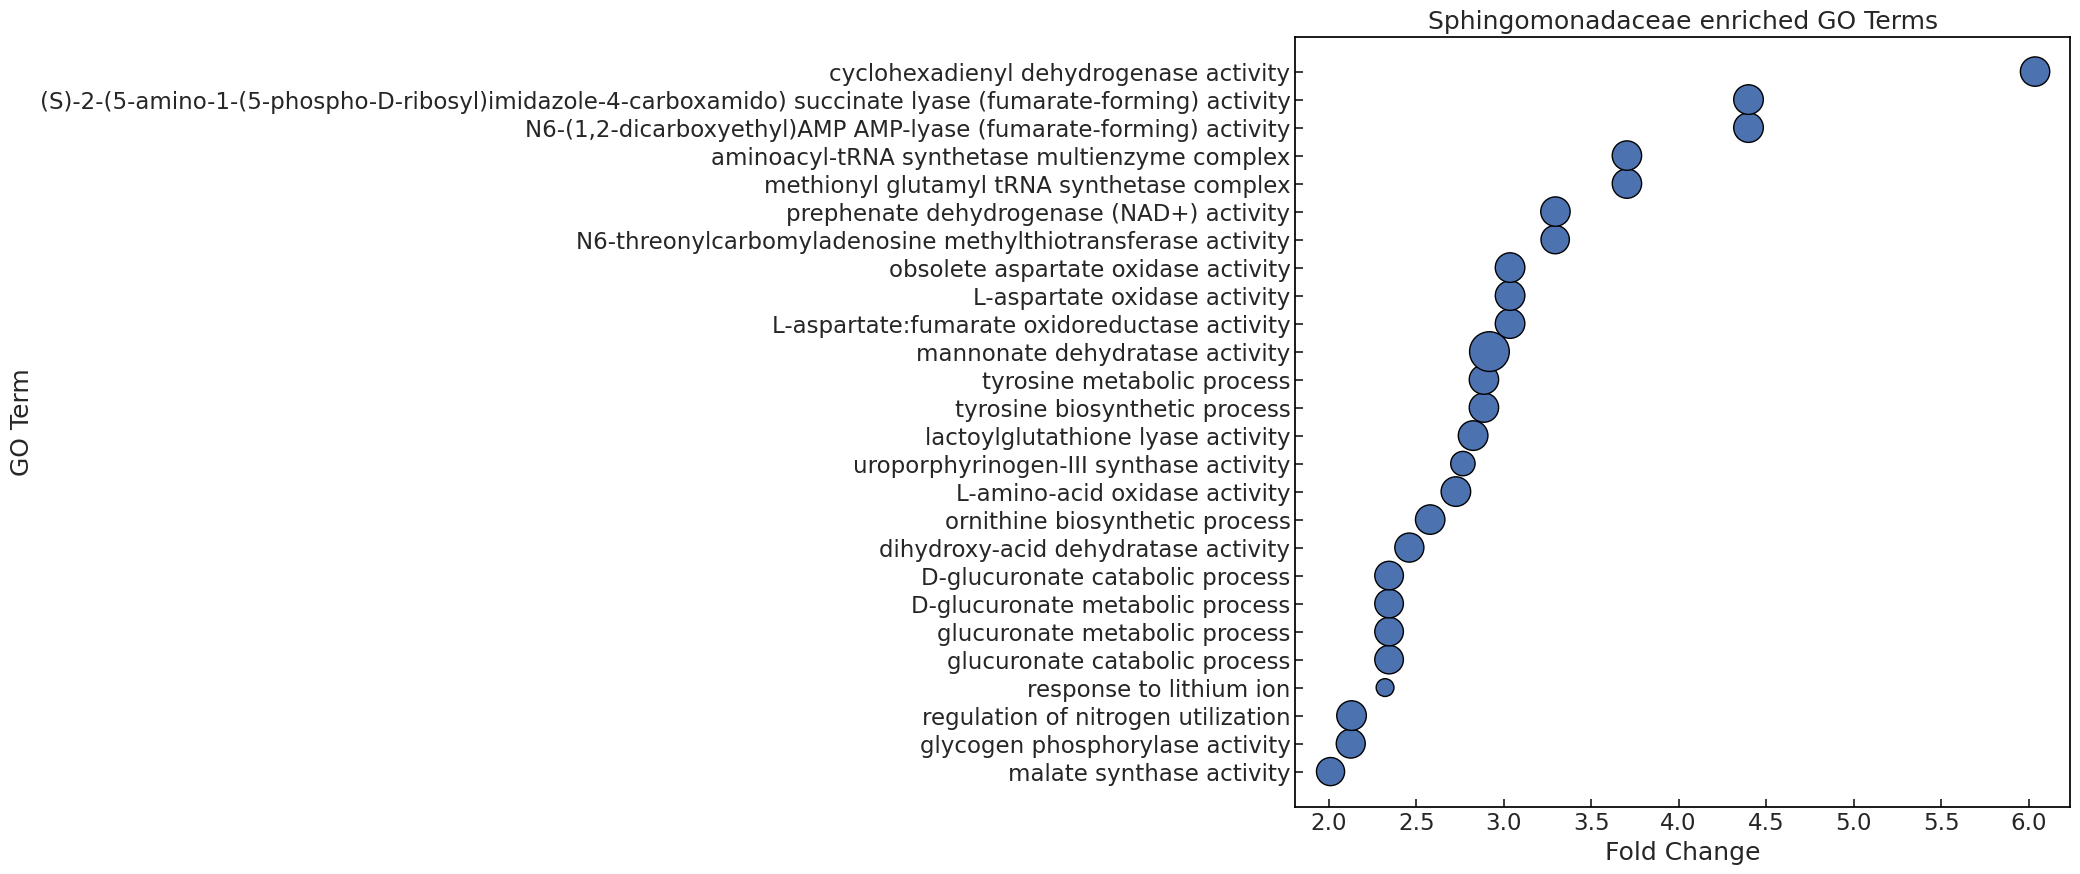

In [26]:
#make a plot of the top 10 most abundant GO terms in sphingomonadaceae versus non-sphingomonadaceae
#the figure should have dots representing each GO term, with the y axis being the go term and the x axis being the fold change
#the size of the dot should be the number of genes with that GO term
#the color of the dot should be the fold change
#the dot should be labeled with the GO term


# create a df with GO terms that have more than 10 counts in both sphingomonadaceae and non-sphingomonadaceae, add the name of the GO term from the go_translation_table
filtered_go_df = go_df[(go_df['Sphingomonadaceae'] > 100) & (go_df['Non-Sphingomonadaceae'] > 100)]
filtered_go_df['GO_name'] = filtered_go_df.index.map(go_translation_table)
# keep go terms that have a fold change of more than 2
filtered_go_df = filtered_go_df[filtered_go_df['fold_change'] > 2]
filtered_go_df.sort_values(by='fold_change', ascending=False, inplace=True)
filtered_go_df = filtered_go_df.iloc[:100]
print (filtered_go_df)
#use the GO name as the index
filtered_go_df.set_index('GO_name', inplace=True)
filtered_go_df.sort_values(by='fold_change', ascending=True, inplace=True)
#make a plot
#use the GO name as the label
#blue dots with black outline
#reverse the y axis so that the most abundant GO terms are on top

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(filtered_go_df['fold_change'], filtered_go_df.index, s=filtered_go_df['Sphingomonadaceae'], edgecolors='black')
ax.set_xlabel('Fold Change')
ax.set_ylabel('GO Term')
ax.set_title('Sphingomonadaceae enriched GO Terms')
plt.show()
plt.close()



            Sphingomonadaceae  Non-Sphingomonadaceae  fold_change
GO:0065009                140                   9254     0.026766
GO:0050790                136                   8207     0.029318
GO:0098772                121                   4480     0.047785
GO:0040007               1077                  38968     0.048898
GO:0030234                120                   4283     0.049570
...                       ...                    ...          ...
GO:0000287               2116                  23623     0.158477
GO:0043649                170                   1885     0.159559
GO:0016021               3671                  40598     0.159979
GO:0015893                855                   9434     0.160345
GO:0005887               2912                  32130     0.160349

[100 rows x 3 columns]


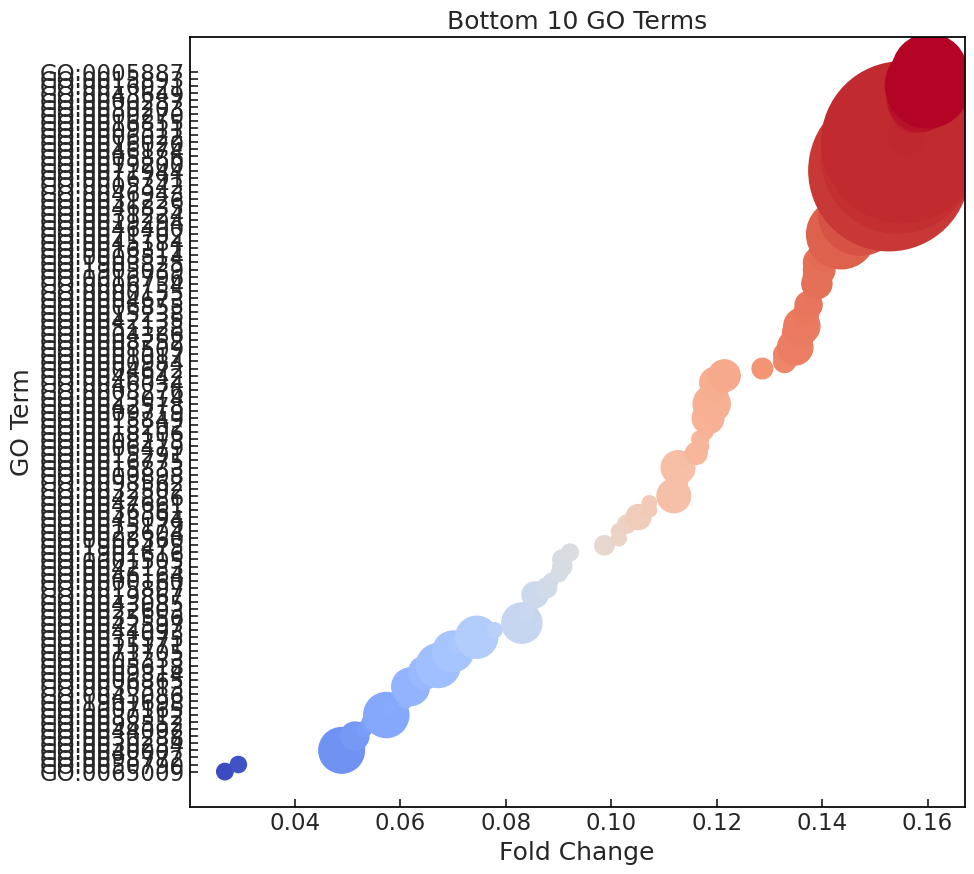

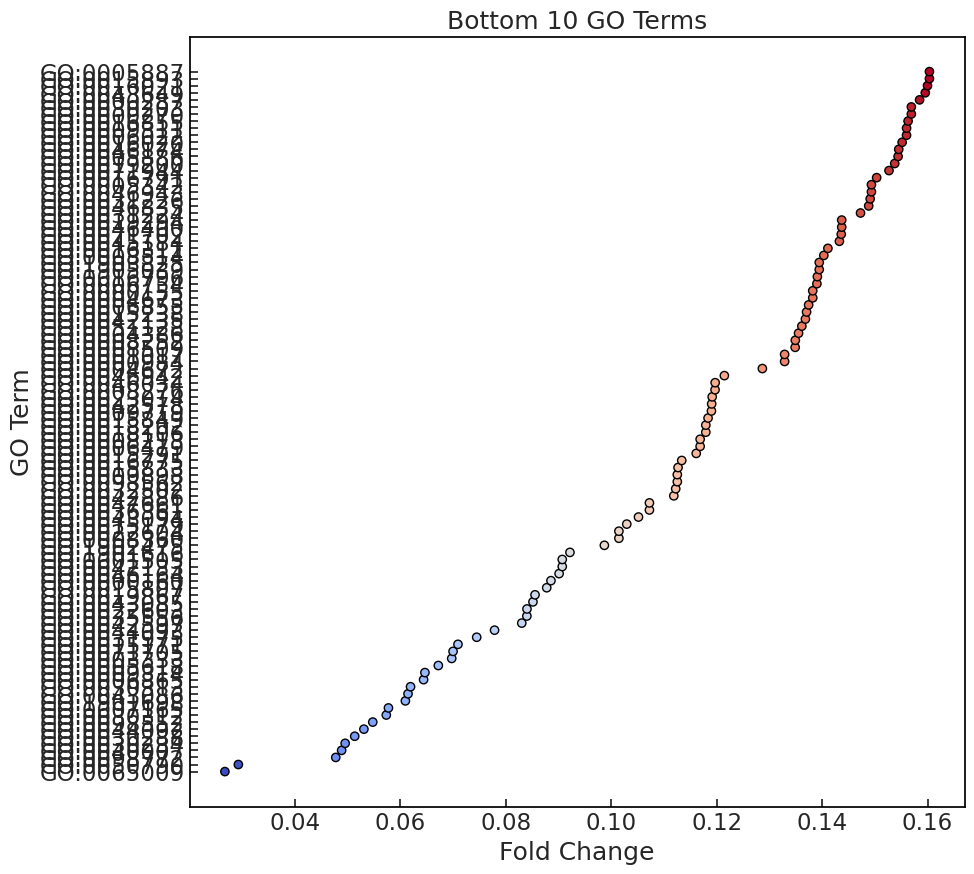

In [38]:
#do the same for the bottom 10 GO terms

filtered_go_df = go_df[(go_df['Sphingomonadaceae'] > 100) & (go_df['Non-Sphingomonadaceae'] > 100)]
filtered_go_df = filtered_go_df[filtered_go_df['fold_change'] < 0.5]
filtered_go_df.sort_values(by='fold_change', ascending=True, inplace=True)
filtered_go_df = filtered_go_df.iloc[:100]
print (filtered_go_df)

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(filtered_go_df['fold_change'], filtered_go_df.index, s=filtered_go_df['Sphingomonadaceae'], c=filtered_go_df['fold_change'], cmap='coolwarm')
ax.set_xlabel('Fold Change')
ax.set_ylabel('GO Term')
ax.set_title('Bottom 10 GO Terms')
plt.show()
plt.close()

fig, ax = plt.subplots(figsize=(10,10))
ax.scatter(filtered_go_df['fold_change'], filtered_go_df.index,  c=filtered_go_df['fold_change'], cmap='coolwarm', edgecolors='black')
ax.set_xlabel('Fold Change')
ax.set_ylabel('GO Term')
ax.set_title('Bottom 10 GO Terms')
plt.show()
plt.close()